## Importing libraries

In [2391]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Loading and formatting the data

In [2392]:
id_num = ['85065', '85012', '85064', '85030',
      '85054', '95040']
id_n = '85065'

In [2393]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id="+id_n;
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Loading some additional data for modeling (weather)

In [2394]:
pd.set_option('display.max_rows', 5000)
df.iloc[[0, -1]]

,Value,Date
0,276.488,2006-01-01
4016,275.900,2016-12-31


In [2395]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2009&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);


## Data Fusion

In [2396]:
# make date a key in our data
df.set_index('Date', inplace=True);

In [2397]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [2398]:
ds = ds.loc['2010-01-01':'2015-01-01']

# .........

In [2399]:
ds['DValue'] = ds['Value'] - ds['Value'].shift(1)

In [2400]:
#shift of data for n days
def shift_of_data(string, data, new_data):
    for i in range(26):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)
    for i in range(30,101,10):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)

In [2401]:
import copy
dnew = copy.deepcopy(ds)

data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

for string in data_names:
    shift_of_data(string, ds, dnew)

In [2402]:
#dnew

In [2403]:
#dnew.corr()

In [2404]:
#average for last n days
def average_last_n_days(string, data, new_data):
    for i in range(1,26):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i
    for i in range(30,101,10):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i

In [2405]:
#data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
#              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

#dnew2 = copy.deepcopy(ds)
for string in data_names:
    average_last_n_days(string, ds, dnew)  

In [2406]:
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

Percipitation = dsort['DValue'].index[1]
Sun = dsort['DValue'].index[-1]
for i in dsort['DValue'].index:
    if 'CloudCover' in i:
        Cloud = i
        break
dsort['DValue']   

DValue                           1.000000
Percipitation_average_3d         0.780814
Percipitation_average_4d         0.780157
Percipitation_average_5d         0.748609
Percipitation_average_6d         0.709014
Percipitation_average_2d         0.687585
Percipitation_average_7d         0.669847
Percipitation_average_8d         0.637528
Percipitation_shift_1d           0.629819
Percipitation_average_9d         0.610103
Percipitation_average_10d        0.590176
Percipitation_average_11d        0.575449
Percipitation_average_12d        0.559235
Percipitation_average_13d        0.541071
Percipitation_average_14d        0.524484
Percipitation_average_15d        0.505901
Percipitation_average_16d        0.485387
Percipitation_shift_2d           0.480551
Percipitation_average_17d        0.468426
Percipitation_average_18d        0.461497
Percipitation_average_1d         0.457381
Percipitation                    0.457381
Percipitation_shift_0d           0.457381
Percipitation_average_19d        0

In [2407]:
#create new data frame for chosen colerated quantities
data_corelated = pd.DataFrame()
corelated = [Percipitation,
             Cloud,
             Sun,
             #'Percipitation_average_6d',
             #'Percipitation_average_10d',
             #'Percipitation_average_25d',
             #'CloudCover_average_9d',
             #'Sun_duration_average_9d'
            ]
corelated = ['Percipitation_average_6d',
             'Percipitation_average_10d',
             'Percipitation_average_25d',
             'CloudCover_average_18d',             
             'CloudCover_average_9d',
             'Snow_blanket_shift_50d',
             'Snow_blanket_shift_30d',
             'New_snow_blanket_average_60d',
             'Sun_duration_average_10d',
             'Sun_duration_average_3d',
             'TemperatureAvg_average_3d',
             ]
data_corelated['DValue'] = copy.deepcopy(dnew['DValue'])

for corelated in corelated:
    data_corelated[corelated] = copy.deepcopy(dnew[corelated])


In [2408]:
data_corelated

,DValue,Percipitation_average_6d,Percipitation_average_10d,Percipitation_average_25d,CloudCover_average_18d,CloudCover_average_9d,Snow_blanket_shift_50d,Snow_blanket_shift_30d,New_snow_blanket_average_60d,Sun_duration_average_10d,Sun_duration_average_3d,TemperatureAvg_average_3d
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.666667e+00,2.966667e+00
2010-01-04,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.933333e+00,-4.333333e-01
2010-01-05,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.933333e+00,-1.766667e+00
2010-01-06,-0.01,7.083333e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.666667e-01,-1.833333e+00
2010-01-07,-0.03,5.516667e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.220446e-16,-5.333333e-01
2010-01-08,-0.02,5.033333e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.220446e-16,-1.000000e-01
2010-01-09,-0.02,1.015000e+01,NaN,NaN,NaN,86.777778,NaN,NaN,NaN,NaN,2.220446e-16,3.666667e-01


In [2409]:
n=data_corelated['DValue'].isnull().sum()
data_corelated = data_corelated.fillna(0); #missing data replace vith 0
n

1

# Learn

In [2410]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error, r2_score

In [2411]:
#create arrays x (corelated) and y ('DValue')
#y = dnew['Value']
y = data_corelated['DValue']
y = y.values.astype(np.float)[100:]
X = data_corelated.iloc[:, 1:len(corelated)]
X= X.values.astype(np.float)[100:]

In [2412]:
(y.shape,X.shape)

((1727,), (1727, 11))

In [2413]:
(np.isnan(y).any(),np.isnan(X).any())

(False, False)

In [2414]:
#choose regressor

regressor = linear_model.LinearRegression();
#regressor = DecisionTreeRegressor();
#regressor = RandomForestRegressor();
#regressor = SVR();
#regressor = GradientBoostingRegressor();

In [2415]:
#predict
predicted = cross_val_predict(regressor, X, y, cv = 3)

<IPython.core.display.Javascript object>


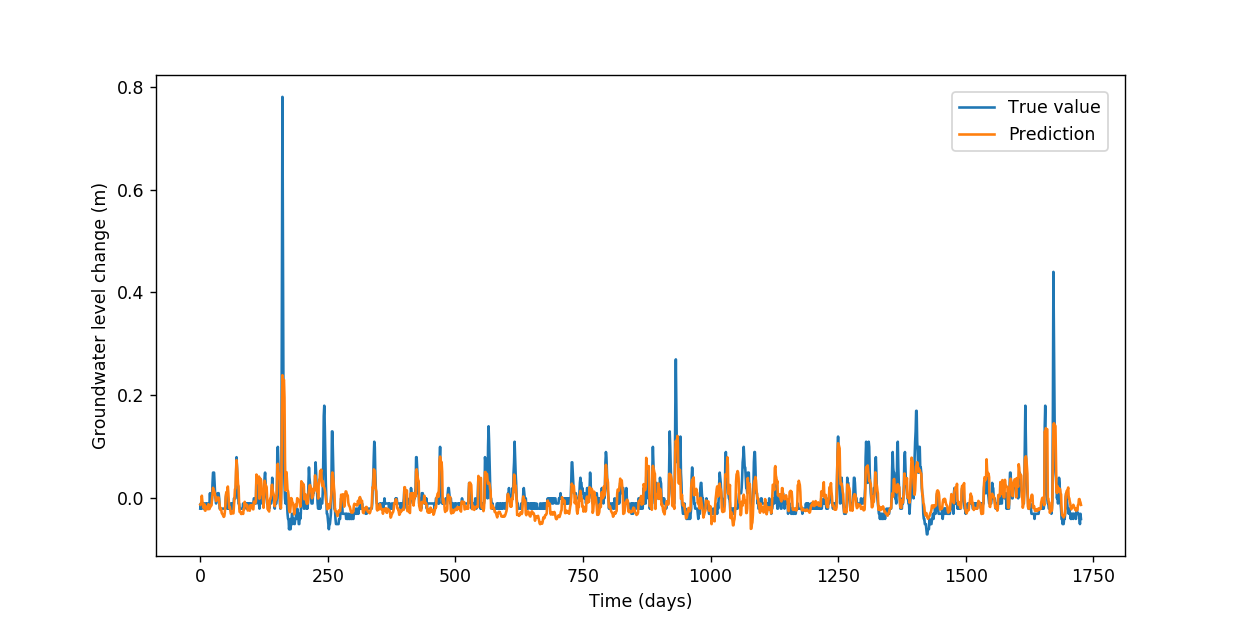

In [2416]:
#plot predicted values and real value
fig, ax = plt.subplots(); 
#fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(y)), y, label="True value")
ax.plot(range(len(y)), predicted, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level change (m)')
plt.show();

In [2417]:
#fig.savefig('./graphs/prediction_'+'id='+ id_n +'.png', dpi=300)

In [2418]:
#evaluate results

mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)

(0.0009641197027537915, 0.4900222457798382)

In [2419]:
#evaluation for all regressors
regressor_list = (linear_model.LinearRegression(),
            DecisionTreeRegressor(),
            RandomForestRegressor(),
            GradientBoostingRegressor(),
            SVR(),
            MLPRegressor()
            )
score=[]
for regressor in regressor_list:
    predicted = cross_val_predict(regressor, X, y, cv = 3)
    mse = mean_squared_error(y, predicted)
    r2 = r2_score(y, predicted);
    print(mse, r2)
    score.append([mse,r2])

0.0009641197027537915 0.4900222457798382
0.0015411696583668812 0.18478769907795534
0.0009688986682107383 0.48749437910076476
0.00106860177249327 0.43475573568796766
0.007115148195820162 -2.7636066221692333
0.04384043973736606 -22.189702417061575


In [2420]:
#sum
value = ds['Value']
value = value.values.astype(np.float)[100:]

predicted_value = []
predicted_value.append(value[0])
n=1
for i in predicted[1:]:
    predicted_value.append(predicted_value[n-1] + i)
    n += 1

<IPython.core.display.Javascript object>


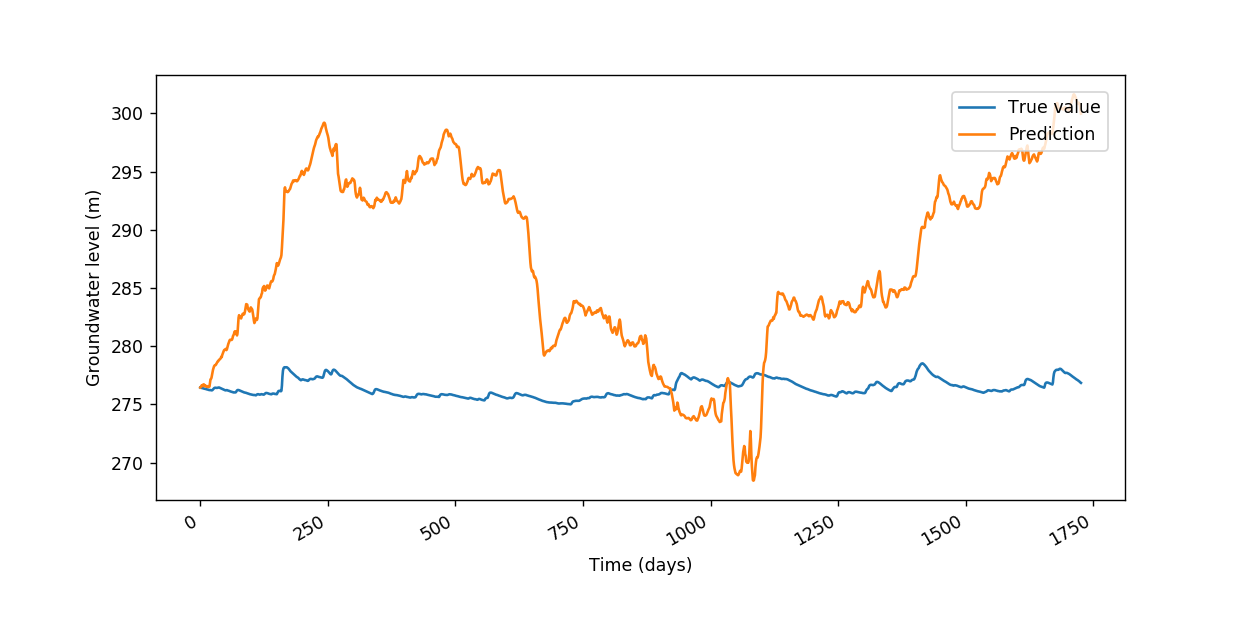

In [2421]:
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(value)), value, label="True value");
ax.plot(range(len(value)), predicted_value, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level (m)')
plt.show();

In [2422]:
#fig.savefig('./graphs/prediction_cum_'+'id='+ id_n +'.png', dpi=300)

In [2423]:
str(score[0][1])

'0.4900222457798382'

In [2424]:
regressor = ('LinearRegression(): ',
            'DecisionTreeRegressor(): ',
            'RandomForestRegressor(): ',
            'GradientBoostingRegressor(): ',
            'SVR(): ',
            'MLPRegressor(): '
            )
j=0

#file = open('./graphs/id='+ id_n +'.txt','w')
file = open('test.txt','w')

file.write('id = '+ id_n)
file.write('\n')
file.write('Training data: ' 
           + Percipitation + ', ' + Cloud + ', ' + Sun +'\n')
file.write('Regressor, mse, R2 \n')
for i in regressor:
    file.write(i + str(score[j][0])+ '  ' + str(score[j][1]) + '\n')
    j += 1



file.close() 